# Classifier selection
Training data should be all set, let's take a quick look for sanity and then dig into building the text classifier. Plan here is to try a bunch of different things, follow any interesting ideas or insights and see what sticks. Some thoughts to get started:

1. ~~Should we use the DMLC XGBoost package or the gradient boosting classifier included in scikit-learn?~~ Use XGBoost via the scikit-learn API, classification performance is similar to scikit-learn's gradient boosting classifier, but it's much faster.

2. ~~Binary cross entropy seems like the obvious loss function to use, but what metrics should we track?~~

    - The default for XGBoost on this type of task is '**binary:logistic**' - but I haven't found exactly what that loss function is yet...
    - For scikit-learn gradient boosting classifier the default is '**log_loss**' which, according to the documentation 'refers to binomial and multinomial deviance, the same as used in logistic regression'.

    Ok, fine - only way I see to confirm that those are the same is dig into the source code. Definitely not worth the effort. At the end of the day, exactly what/how it is optimized and if it's the same between the two frameworks does not really matter - what we need is a way to evaluate both of them.

    I like false positive and false negative rates, we can get those from the confusion matrix (and also plot that at the same time). We should probably include accuracy as a percent for the less-statistically minded. We need a third to give a good look at the underlying probabilities rather than the 'calls'. Let's go with binary cross-entropy, in scikit-learn the **log_loss**.
    
3. ~~Do some hyperparameter tuning.~~ Done.
4. ~~Make sure we can do k-fold cross validation rather than looking at the test data all the time.~~ Done.
5. ~~Is there an easy way to do early stopping?~~ Yep - it's built into the sklearn API.
6. Is there an easy way to make training plots (i.e. training & validation loss over time)?
7. What about random forest?
8. Take a look at examples we have a hard time with.
9. Take a look at feature importance.
10. Maybe throw in some other methods (i.e. deep neural network/logistic regression), just for completeness.
11. ~~Build a results data structure so we can track the winners at each stage.~~ Done.

In [1]:
# Turn sampling on or off for rapid development
sample = False

# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

/mnt/arkk/llm_detector/classifier


## Load and prepare data
Let's take a look:

In [2]:
with open(config.FEATURE_ENGINEERING_CLASS_INSTANCE, 'rb') as file:
    data = pickle.load(file)

data.training.all.combined.info()
print()
data.training.all.combined.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7162 entries, 0 to 7161
Data columns (total 21 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Source record num                                        7162 non-null   int64  
 1   Fragment length (words)                                  7162 non-null   int64  
 2   Fragment length (tokens)                                 7162 non-null   int64  
 3   Dataset                                                  7162 non-null   object 
 4   Source                                                   7162 non-null   object 
 5   Generator                                                7162 non-null   object 
 6   String                                                   7162 non-null   object 
 7   Perplexity                                               7162 non-null   float64
 8   Cross-perplexity            

,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,Perplexity ratio score,...,Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB),Synthetic-human perplexity ratio Kullback-Leibler score,Human-synthetic perplexity ratio Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF Kullback-Leibler score,Human-synthetic TF-IDF Kullback-Leibler score
0,2463,71,126,cc_news,synthetic,llama2-13b,second half of an NCAA college basketball game...,0.847,1.034180,0.819169,...,2.164324,5.559723,5.530789,4.841244,0.323106,-2.493762,-2.343884,0.725058,0.044533,0.069897
1,721,170,244,cc_news,human,human,and the Dow was on track for its best day in m...,1.999,2.162109,0.924571,...,3.523291,6.131937,6.105052,0.390126,0.941775,-3.202511,-3.076281,0.792569,0.039971,0.075741
2,527,352,475,cc_news,human,human,Singer-songwriter Melissa Bret connects with b...,2.627,2.482422,1.058222,...,6.604019,9.247959,9.154001,0.339599,2.790049,-3.352111,-3.136990,1.395941,0.017950,0.123178
3,2399,108,139,cc_news,synthetic,llama2-13b,"wrote, especially one where I was an integral ...",2.560,2.871094,0.891837,...,2.742790,5.785101,5.746893,1.566740,0.187165,-3.114587,-3.161835,-0.296548,0.133121,0.017673
4,1661,41,46,cnn,synthetic,falcon7,jobs are safe any more. That is why so many do...,3.459,3.458984,1.000000,...,1.145596,4.934512,4.926190,0.145266,3.530649,-3.443841,-3.268660,1.175899,0.022210,0.108170


OK, let's get the data into shape to train a classifier.

In [3]:
# Set length threshold
training_data_df = data.training.all.combined[data.training.all.combined['Fragment length (words)'] > 50].copy()
testing_data_df = data.testing.all.combined[data.training.all.combined['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary and highly correlated features
feature_drops = [
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Keep a dataframe copy of the features for easy manipulation later and make 
# a numpy copy for training without the dataset or string columns
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

print(f'Training data: {len(labels_train)} examples')
print(f'Test data: {len(features_test)} examples')


Training data: 5832 examples
Test data: 1472 examples


/tmp/ipykernel_749407/1336799590.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testing_data_df = data.testing.all.combined[data.training.all.combined['Fragment length (words)'] > 50].copy()


Take a look at the features we are working with:

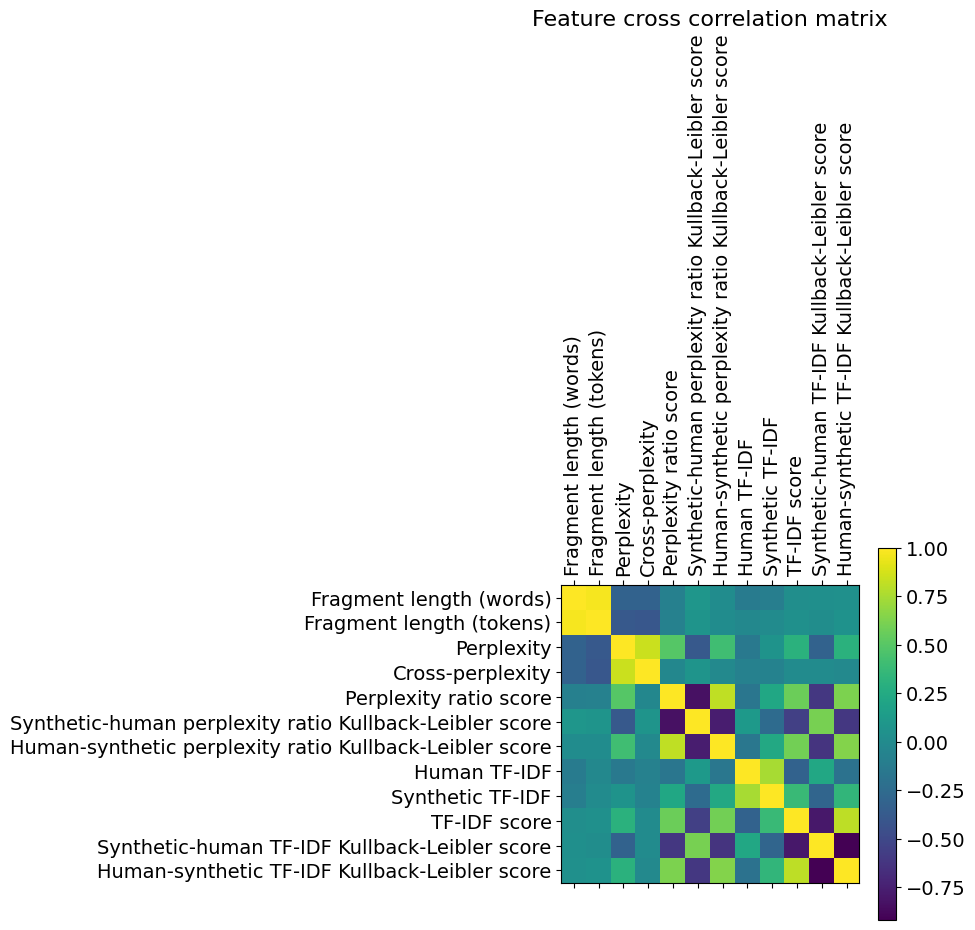

In [4]:
plt.matshow(features_train_df.corr())
plt.xticks(range(features_train_df.select_dtypes(['number']).shape[1]), features_train_df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(features_train_df.select_dtypes(['number']).shape[1]), features_train_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)
plt.title('Feature cross correlation matrix', fontsize=16)
plt.show()

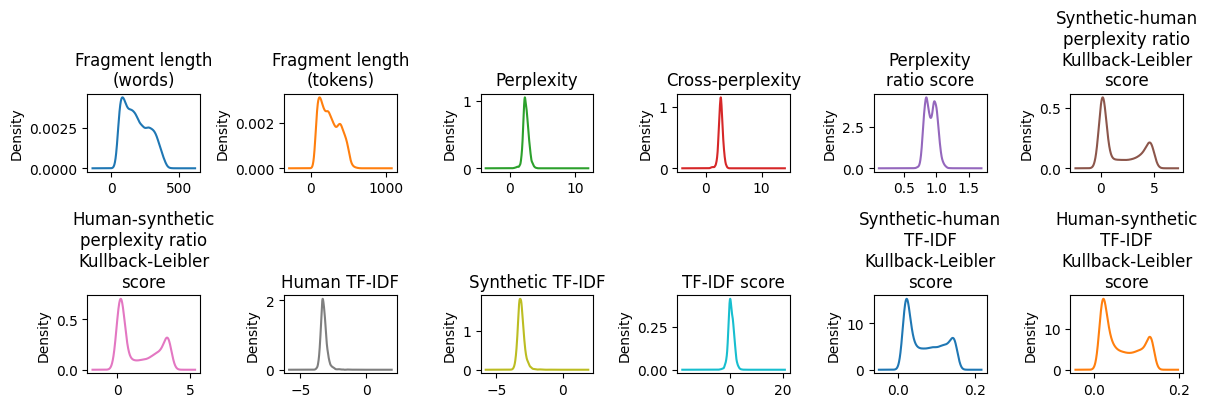

In [5]:
plot_titles = list(training_data_df.drop(['Source'], axis = 1).columns)
plot_titles = ['Synthetic-human\nperplexity ratio\nKullback-Leibler\nscore' if x=='Synthetic-human perplexity ratio Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nperplexity ratio\nKullback-Leibler\nscore' if x=='Human-synthetic perplexity ratio Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Perplexity\nratio score' if x=='Perplexity ratio score' else x for x in plot_titles]
plot_titles = ['Synthetic-human\nTF-IDF\nKullback-Leibler\nscore' if x=='Synthetic-human TF-IDF Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Human-synthetic\nTF-IDF\nKullback-Leibler\nscore' if x=='Human-synthetic TF-IDF Kullback-Leibler score' else x for x in plot_titles]
plot_titles = ['Fragment length\n(words)' if x=='Fragment length (words)' else x for x in plot_titles]
plot_titles = ['Fragment length\n(tokens)' if x=='Fragment length (tokens)' else x for x in plot_titles]

n_cols = len(features_train_df.columns) // 2
n_rows = (len(features_train_df.columns) // 2) + (len(features_train_df.columns) % 2)

features_train_df.plot(title = plot_titles, kind = 'density', subplots = True, sharex = False, legend = False, layout = (n_rows,n_cols), figsize = (12,12))
plt.tight_layout()
plt.show()

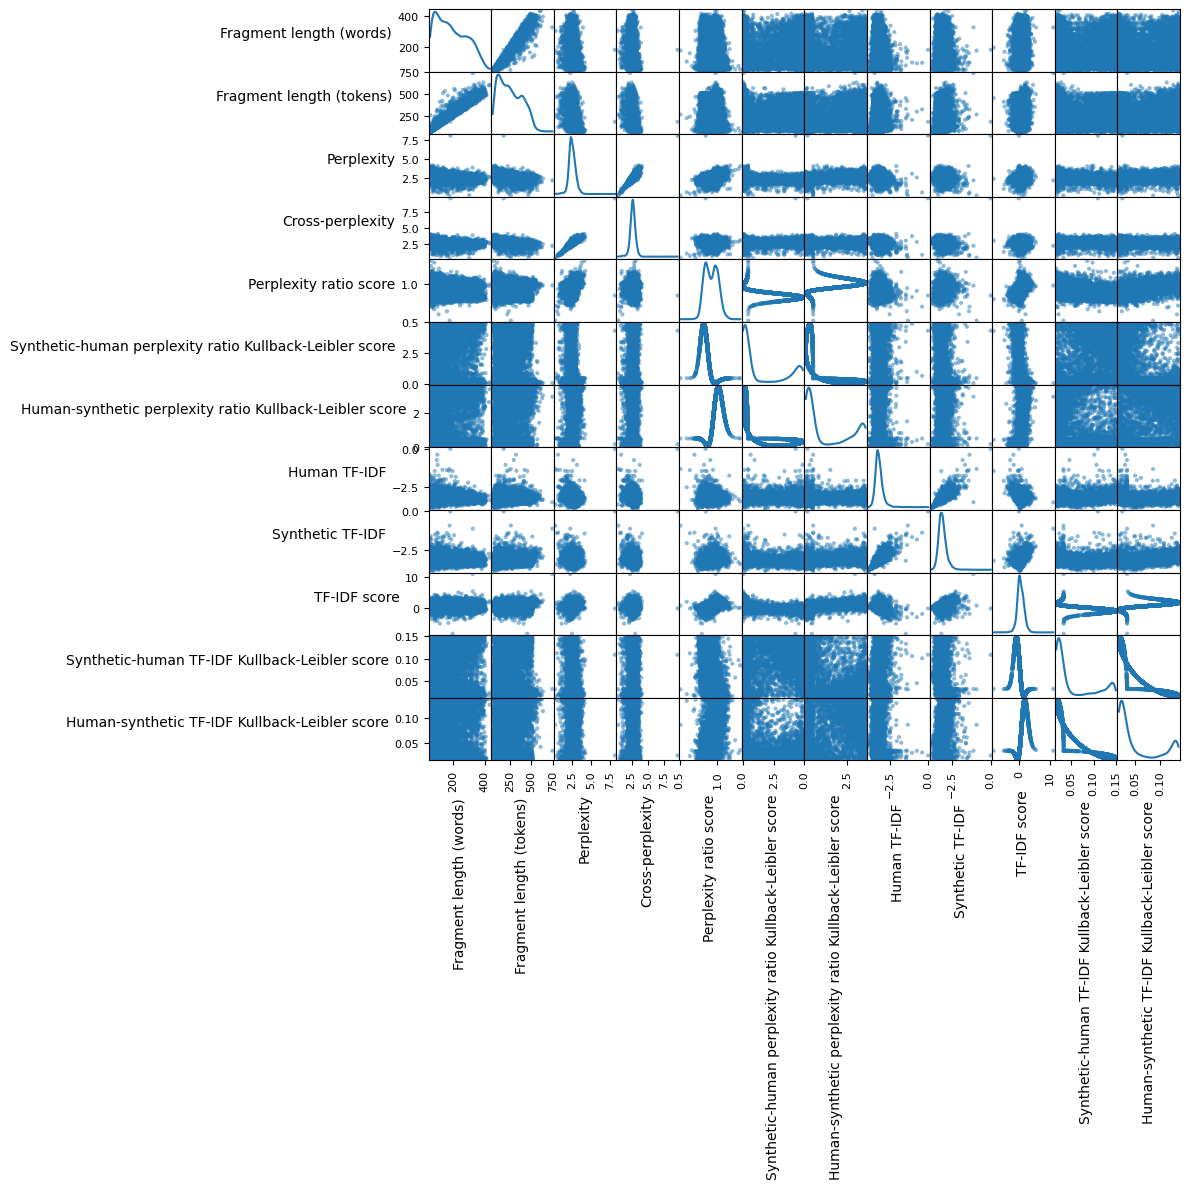

In [6]:
axes = scatter_matrix(features_train_df, figsize=(12,12), diagonal='kde')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

Let's also make a data structure to collect results for plotting as we go.

In [7]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

## 3. Off-the-shelf classifiers

In [8]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

In [9]:
# Some parameters
kfolds = 3
random_state = 23
parallel_jobs = 16

### 2.1. XGBoost XGBClassifier

In [10]:
%%time 

# Instantiate an XGBoost model using the sklearn API
model = XGBClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'XGBC')

Model is: <class 'xgboost.sklearn.XGBClassifier'>

CPU times: user 45.6 ms, sys: 198 ms, total: 244 ms
Wall time: 1.77 s


### 2.2. scikit-learn GradientBoostingClassifier

In [11]:
%%time

# Instantiate sklearn gradient boosting classifier
model = GradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'GBC')

Model is: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>

CPU times: user 17.9 ms, sys: 1.46 ms, total: 19.3 ms
Wall time: 3.1 s


### 2.3. scikit-learn HistGradientBoostingClassifier

In [12]:
%%time

from sklearn.ensemble import HistGradientBoostingClassifier

# Instantiate sklearn gradient boosting classifier
model = HistGradientBoostingClassifier(random_state = random_state)

print(f'Model is: {type(model)}\n')

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'HGBC')

Model is: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>

CPU times: user 13.9 ms, sys: 1.1 ms, total: 15 ms
Wall time: 1.79 s


### 2.4. Results

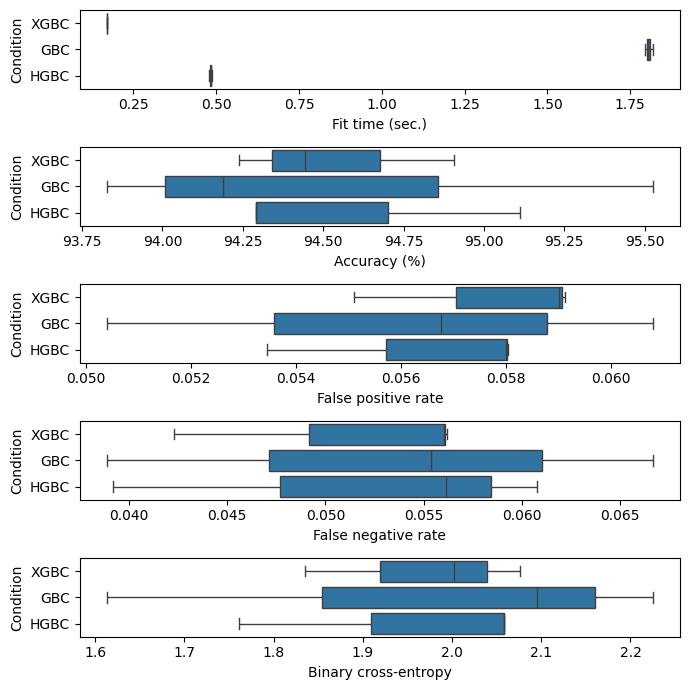

In [13]:
plot_funcs.plot_cross_validation(plots, results).show()

OK, pretty good - we are not over-fitting or just guessing the major class, we are in the mid-low 90% accuracy for all three implementation. This is actually a pretty good bump over the LLaMA2 based perplexity ratio score where we never got better than 88%. Problem now is as before, high false positive rate >= 15% for all three implementations. We may be able to mitigate that somewhat at the cost of false negatives with some threshold tuning later. First let's do some:

## 3. Hyperparameter optimization

In [14]:
# How many iterations to run
n_iter = 500

# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'max_iter': scope.int(hp.quniform('max_iter', 10, 1000, 1)),
       'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 15, 60, 1)),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 1000, 1)),
       'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 100, 1)),
       'l2_regularization': hp.uniform('l2_regularization', 0.001, 1.0)
}

### 3.1. HistGradientBoostingClassifier: single training-validation split

In [15]:
# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 500/500 [01:43<00:00,  4.82trial/s, best loss: 1.7918844827732527]


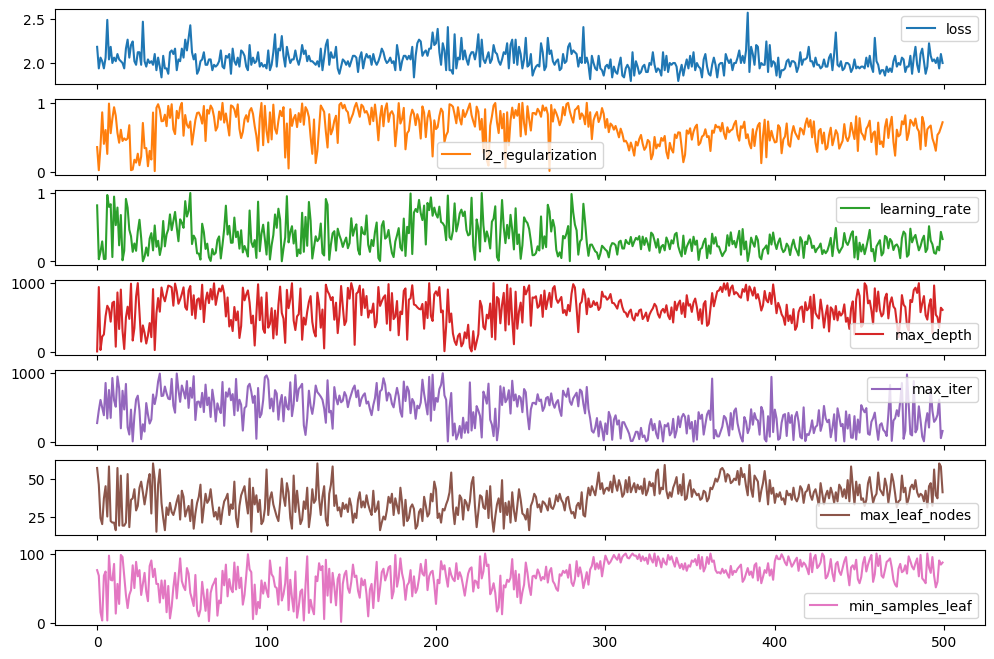

In [16]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [17]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best['learning_rate'],
    max_iter = int(best['max_iter']),
    max_leaf_nodes = int(best['max_leaf_nodes']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    l2_regularization = best['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized HGBC')


Optimized parameters:

 l2_regularization: 0.4242912001580703
 learning_rate: 0.3548552892102097
 max_depth: 613.0
 max_iter: 18.0
 max_leaf_nodes: 41.0
 min_samples_leaf: 97.0



### 3.2. HistGradientBoostingClassifier with k-fold cross validation

In [18]:
# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
       early_stopping = True,
       validation_fraction = 0.1,
       n_iter_no_change = 10, 
       random_state = random_state
)

# Set up trial logging
trials_cv = Trials()

best_cv = fmin(
       fn = partial(
              helper_funcs.hyperopt_cv,
              model = model,
              features = features_train, 
              labels = labels_train
       ),
       space = space,           # Parameter: value dictionary
       algo = tpe.suggest,      # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,      # Maximum number of iterations
       trials = trials_cv       # Logging
)

100%|██████████| 500/500 [16:12<00:00,  1.94s/trial, best loss: 1.875110500387199] 


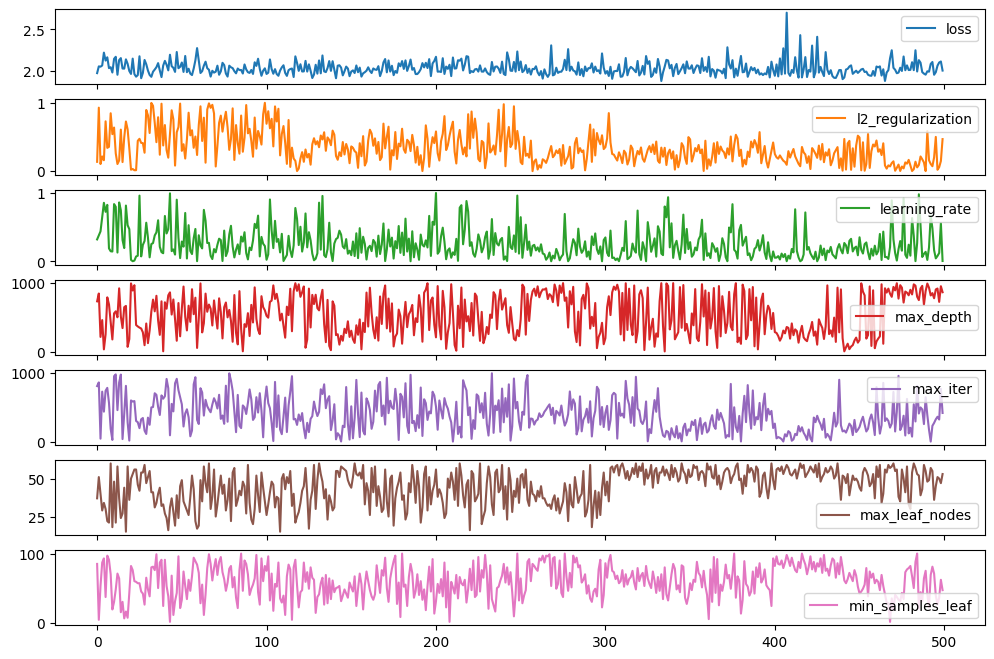

In [19]:
optimization_plot = plot_funcs.make_optimization_plot(trials_cv.trials)

In [20]:
print('Optimized parameters:\n')

for key, value in best_cv.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = HistGradientBoostingClassifier(
    learning_rate = best_cv['learning_rate'],
    max_iter = int(best_cv['max_iter']),
    max_leaf_nodes = int(best_cv['max_leaf_nodes']),
    max_depth = int(best_cv['max_depth']),
    min_samples_leaf = int(best_cv['min_samples_leaf']),
    l2_regularization = best_cv['l2_regularization'],
    early_stopping = True,
    validation_fraction = 0.1,
    n_iter_no_change = 10, 
    random_state = random_state
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'CV Optimized HGBC')

Optimized parameters:

 l2_regularization: 0.3448002978486334
 learning_rate: 0.11384936839695664
 max_depth: 999.0
 max_iter: 215.0
 max_leaf_nodes: 54.0
 min_samples_leaf: 70.0



### 3.3. XGBClassifier: single training-validation split

In [21]:
# Parameter optimization space
space = {
       'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
       'gamma': hp.uniform('gamma', 0.0, 10.0),
       'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 1)),
       'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
       'subsample': hp.uniform('subsample', 0.5, 1.0),
       'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
       'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
       'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
       'num_parallel_tree': scope.int(hp.quniform('num_parallel_tree', 1, 10, 1))
}

# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = 0.3,
    random_state = 0
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = XGBClassifier()

best = fmin(
       fn = partial(
              helper_funcs.hyperopt,
              model = model,
              features_training = optimization_features_training, 
              labels_training = optimization_labels_training,
              features_validation = optimization_features_validation, 
              labels_validation = optimization_labels_validation
       ),
       space = space,       # Parameter: value dictionary
       algo = tpe.suggest,  # Optimization algorithm, hyperopt will select its parameters automatically
       max_evals = n_iter,  # Maximum number of iterations
       trials = trials      # Logging
)

100%|██████████| 500/500 [02:03<00:00,  4.05trial/s, best loss: 1.853673602868882] 


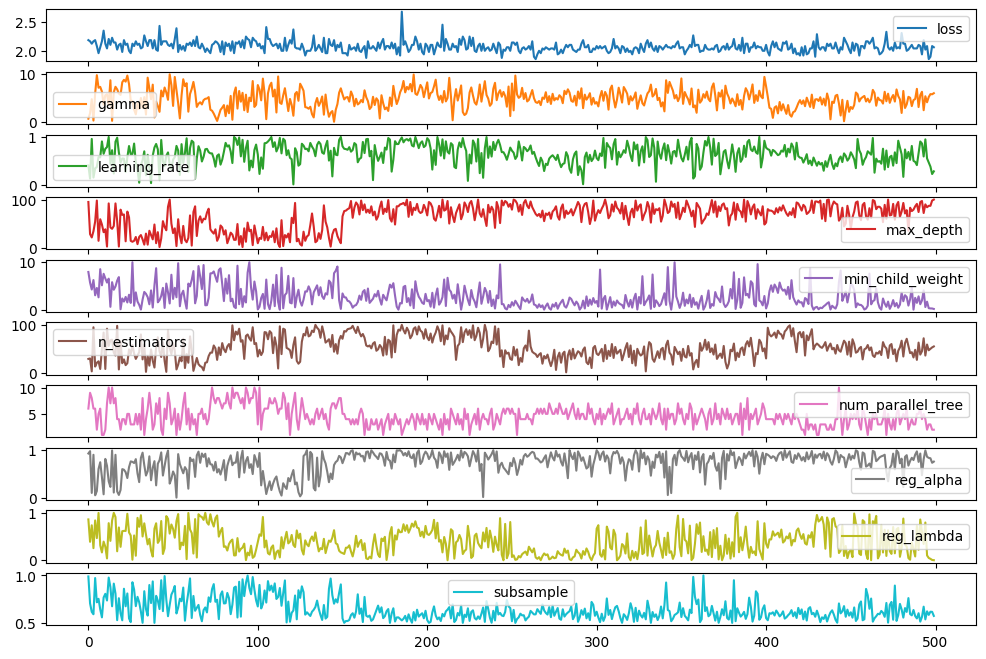

In [22]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [23]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
model = XGBClassifier(
    learning_rate = best['learning_rate'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = int(best['reg_lambda']),
    n_estimators = int(best['num_parallel_tree'])
)

result = model.fit(features_train, labels_train)

# Run cross-validation
scores = cross_validate(
    model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = parallel_jobs,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized XGBC')


Optimized parameters:

 gamma: 5.221034981110121
 learning_rate: 0.46360563670805743
 max_depth: 87.0
 min_child_weight: 0.3198446310713907
 n_estimators: 47.0
 num_parallel_tree: 3.0
 reg_alpha: 0.8375838981354624
 reg_lambda: 0.04868701353144074
 subsample: 0.5844798362903456



### 3.4. Results

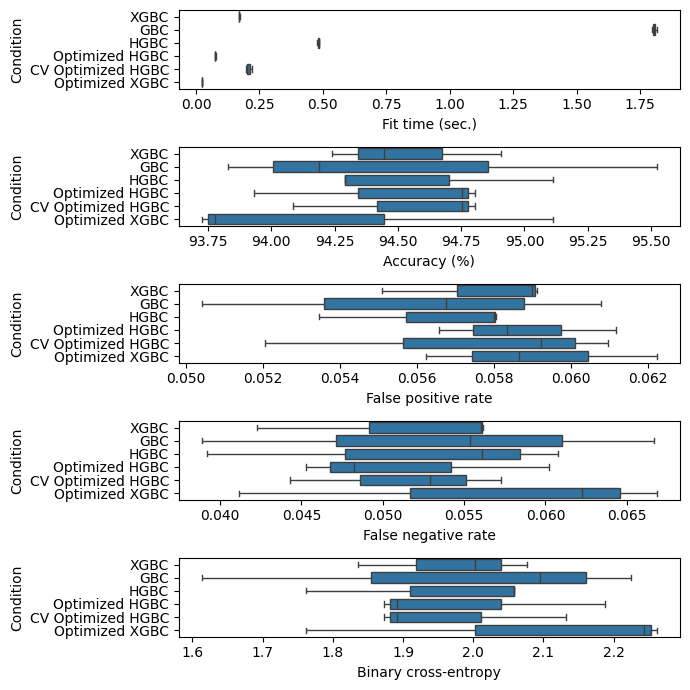

In [24]:
plot_funcs.plot_cross_validation(plots, results).show()

## 4. Synthetic features

In [25]:
# Perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree = 3)
poly_features = trans.fit_transform(features_train)

# Split into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(poly_features, labels_train, test_size = 0.3, random_state = 0)

In [26]:
# Fit model on training data
model = GradientBoostingClassifier()
model.fit(features_train, labels_train)

# Make predictions for test data
y_pred = model.predict(features_test)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(labels_test, predictions)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 94.1%


OK, looks like we are now maxing out at about 96% accuracy. Here's the confusion matrix.


Confusion matrix:
[[822  65]
 [ 38 825]]

Normalized confusion matrix:


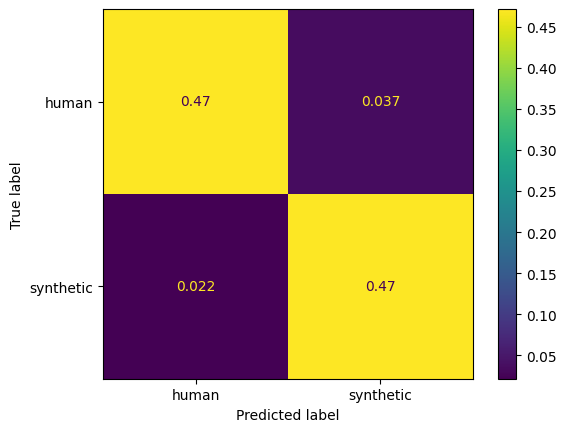

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(labels_test, predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    model, 
    features_test, 
    labels_test, 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)